In [1]:
#https://keras.io/examples/vision/knowledge_distillation/
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
num_epochs = 5

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


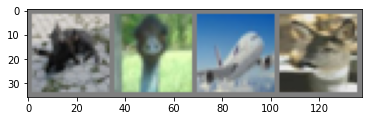

  cat  bird plane  deer


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def base_train_model(network, criterion, optimizer, epochs):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    return network


def knowledge_distillation(network_teacher, network_student, criterion, optimizer, epochs):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            network_teacher.eval()
            with torch.no_grad():
              soft_labels = network_teacher(inputs.to(device))   
            outputs = network_student(inputs.to(device))
            loss = criterion(outputs, soft_labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')    
    return network_student

### Обучение ученика

In [7]:
student_child = Student().to(device)

crtrn = nn.CrossEntropyLoss()
optmzr = optim.SGD(student_child.parameters(), lr=0.001, momentum=0.9)

student_child = base_train_model(student_child, crtrn, optmzr, num_epochs)

[1,  2000] loss: 2.244
[1,  4000] loss: 1.892
[1,  6000] loss: 1.672
[1,  8000] loss: 1.566
[1, 10000] loss: 1.503
[1, 12000] loss: 1.459
[2,  2000] loss: 1.385
[2,  4000] loss: 1.358
[2,  6000] loss: 1.331
[2,  8000] loss: 1.300
[2, 10000] loss: 1.286
[2, 12000] loss: 1.258
[3,  2000] loss: 1.185
[3,  4000] loss: 1.190
[3,  6000] loss: 1.167
[3,  8000] loss: 1.166
[3, 10000] loss: 1.193
[3, 12000] loss: 1.161
[4,  2000] loss: 1.079
[4,  4000] loss: 1.064
[4,  6000] loss: 1.086
[4,  8000] loss: 1.076
[4, 10000] loss: 1.079
[4, 12000] loss: 1.088
[5,  2000] loss: 0.999
[5,  4000] loss: 1.008
[5,  6000] loss: 1.010
[5,  8000] loss: 1.005
[5, 10000] loss: 1.012
[5, 12000] loss: 1.028
Finished Training


In [8]:
PATH = './student_child.pth'
torch.save(student_child.state_dict(), PATH)

### Обучение учителя

In [9]:
teacher = models.resnet34(pretrained=True)
teacher.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(512, len(classes))
)
teacher = teacher.to(device)

In [10]:
teacher = base_train_model(teacher, crtrn, optmzr, num_epochs)

[1,  2000] loss: 2.932
[1,  4000] loss: 2.968
[1,  6000] loss: 2.940
[1,  8000] loss: 2.960
[1, 10000] loss: 2.956
[1, 12000] loss: 2.917
[2,  2000] loss: 2.947
[2,  4000] loss: 2.933
[2,  6000] loss: 2.943
[2,  8000] loss: 2.943
[2, 10000] loss: 2.928
[2, 12000] loss: 2.942
[3,  2000] loss: 2.955
[3,  4000] loss: 2.943
[3,  6000] loss: 2.970
[3,  8000] loss: 2.932
[3, 10000] loss: 2.944
[3, 12000] loss: 2.949
[4,  2000] loss: 2.969
[4,  4000] loss: 2.926
[4,  6000] loss: 2.944
[4,  8000] loss: 2.939
[4, 10000] loss: 2.958
[4, 12000] loss: 2.929
[5,  2000] loss: 2.962
[5,  4000] loss: 2.954
[5,  6000] loss: 2.931
[5,  8000] loss: 2.937
[5, 10000] loss: 2.951
[5, 12000] loss: 2.949
Finished Training


In [11]:
PATH = './teacher.pth'
torch.save(teacher.state_dict(), PATH)

### Knowledge distillation

In [12]:
student_main = Student().to(device)

crtrn = nn.MSELoss()
optmzr = optim.SGD(student_main.parameters(), lr=0.001, momentum=0.9)

In [13]:
student_main = knowledge_distillation(teacher, student_main, crtrn, optmzr, num_epochs)

[1,  2000] loss: 3.497
[1,  4000] loss: 3.473
[1,  6000] loss: 3.171
[1,  8000] loss: 3.251
[1, 10000] loss: 3.628
[1, 12000] loss: 3.363
[2,  2000] loss: 3.354
[2,  4000] loss: 3.472
[2,  6000] loss: 3.143
[2,  8000] loss: 3.635
[2, 10000] loss: 4.281
[2, 12000] loss: 3.609
[3,  2000] loss: 3.497
[3,  4000] loss: 3.334
[3,  6000] loss: 3.621
[3,  8000] loss: 3.704
[3, 10000] loss: 3.435
[3, 12000] loss: 3.247
[4,  2000] loss: 3.329
[4,  4000] loss: 3.450
[4,  6000] loss: 3.311
[4,  8000] loss: 3.725
[4, 10000] loss: 3.519
[4, 12000] loss: 3.613
[5,  2000] loss: 3.404
[5,  4000] loss: 3.564
[5,  6000] loss: 3.445
[5,  8000] loss: 3.507
[5, 10000] loss: 3.481
[5, 12000] loss: 3.572
Finished Training


In [14]:
PATH = './student_main.pth'
torch.save(student_main.state_dict(), PATH)

### Анализ

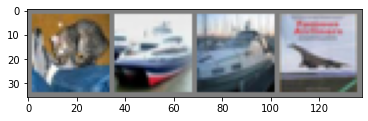

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
path_student_main = "./student_main.pth"
path_student_child = "./student_child.pth"

In [17]:
student_main = Student()
student_main.load_state_dict(torch.load(path_student_main))

student_child = Student()
student_child.load_state_dict(torch.load(path_student_child))

<All keys matched successfully>

In [18]:
student_main.to(device).eval()
student_child.to(device).eval()

Student(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
with torch.no_grad():
  labels_list = []
  student_main_outs = []
  student_child_outs = []

  for i, data in enumerate(testloader, 0):
          
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          labels_list.append(labels.tolist())
          # zero the parameter gradients

          # forward + backward + optimize
          student_main_outs.append(torch.max(student_main(inputs.to(device))))
          student_child_outs.append(torch.max(student_child(inputs.to(device))))

In [20]:
correct_student_main = 0
correct_student_child = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        
        outputs_student_main = student_main(images.to(device))
        outputs_student_child = student_child(images.to(device))
        
        _, predicted_student_main = torch.max(outputs_student_main.data, 1)
        _, predicted_student_child = torch.max(outputs_student_child.data, 1)

        total += labels.size(0)
        
        correct_student_main += (predicted_student_main == labels).sum().item()
        correct_student_child += (predicted_student_child == labels).sum().item()

print(f'Точность классификатора: {100 * correct_student_child / total}')
print(f'Точность ученика (KD): {100 * correct_student_main / total}')

Точность классификатора: 61.24
Точность ученика (KD): 10.0


In [21]:
# prepare to count predictions for each class
correct_pred_student_main = {classname: 0 for classname in classes}
correct_pred_student_child = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        
        outputs_student_main = student_main(images.to(device))
        outputs_student_child = student_child(images.to(device))

        _, predicted_student_main = torch.max(outputs_student_main.data, 1)
        _, predicted_student_child = torch.max(outputs_student_child.data, 1)

        for label, prediction in zip(labels, predicted_student_main):
            if label == prediction:
                correct_pred_student_main[classes[label]] += 1
            total_pred[classes[label]] += 1

        for label, prediction in zip(labels, predicted_student_child):
            if label == prediction:
                correct_pred_student_child[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname in correct_pred_student_main.keys():
    accuracy_student_main = 100 * float(correct_pred_student_main[classname]) / total_pred[classname]

    accuracy_student_child = 100 * float(correct_pred_student_child[classname]) / total_pred[classname]

    print(f"Точность на классе {classname}: ученик (KD) - {accuracy_student_main}; классификатор - {accuracy_student_child}")

Точность на классе plane: ученик (KD) - 0.0; классификатор - 31.15
Точность на классе car: ученик (KD) - 50.0; классификатор - 39.3
Точность на классе bird: ученик (KD) - 0.0; классификатор - 28.35
Точность на классе cat: ученик (KD) - 0.0; классификатор - 23.75
Точность на классе deer: ученик (KD) - 0.0; классификатор - 30.4
Точность на классе dog: ученик (KD) - 0.0; классификатор - 17.3
Точность на классе frog: ученик (KD) - 0.0; классификатор - 38.1
Точность на классе horse: ученик (KD) - 0.0; классификатор - 30.7
Точность на классе ship: ученик (KD) - 0.0; классификатор - 39.5
Точность на классе truck: ученик (KD) - 0.0; классификатор - 27.65
